**NOTE:** This notebook was worked on while being sick, so please excuse any improperly formulated arguments and limited depth into certain sections (such as optimizing the model further by reducing overfitting and making the model larger)

### Sources Used  
[Traffic sign dataset](https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification)  
[Example notebook on traffic sign dataset](https://www.kaggle.com/code/moh3we5/traffic-sign-dataset-resnet-classification)  
[Tensor flow transfer learning documentation](https://www.tensorflow.org/guide/keras/transfer_learning)  
[Tensor flow using GPU](https://saturncloud.io/blog/cant-run-tensorflow-on-gpu-within-jupyternotebook-heres-how-to-fix-it/#:~:text=In%20conclusion%2C%20if%20you%20can,test%20it%20with%20your%20GPU.)  
[Tensor flow training & evaluating with built in methods documentation](https://www.tensorflow.org/guide/keras/training_with_built_in_methods)   


### Introduction
A Traffic sign dataset will be used, to create a CNN capable of recognizing common traffic signs, these datasets are often used as a component of self driving AI. While most of those implementations tend to use multiple models to narrow down the kind of sign, thereby improving possible classification even with small deviations between similar signs.  
In this notebook a single large model will be trained however.

The dataset used contains 58 classes, covering most common signs, however some classes are labeled as Unkown[n].
For every class ~120 images are present.

In this notebook, transfer learning will be leveraged to obtain a pretrained base model. By using transfer learning, the training process can be greatly reduced and will allow us to utilize layers that have been trained on much larger datasets than the one used here.


In [67]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import pandas as pd

from tensorflow import keras

Enable eager execution, eventho this should be on by default in tf2... Otherwise I will be blocked from converting Tensors to numpy values

In [68]:
tf.config.run_functions_eagerly(True)

Load in the traffic sign dataset

In [69]:
dataset_directory = "Dataset/traffic_Data/DATA/"
labels_path = "Dataset/labels.csv"

In [70]:
dataset = tf.keras.utils.image_dataset_from_directory(dataset_directory, labels='inferred', seed=123)

Found 4170 files belonging to 58 classes.


c:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [71]:
dataset.class_names

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '6',
 '7',
 '8',
 '9']

Due to the dataset using an index for its labels, a conversion has to be made to convert the index labels to the human readable labels

In [72]:
original_class_names = dataset.class_names
csv_labels = pd.read_csv(labels_path)
csv_labels_dict = classid_to_name = dict(zip(csv_labels['ClassId'], csv_labels['Name']))
def relabel(label):
    return csv_labels_dict[int(label)]

Now lets take a look at the dataset with the human readable labels

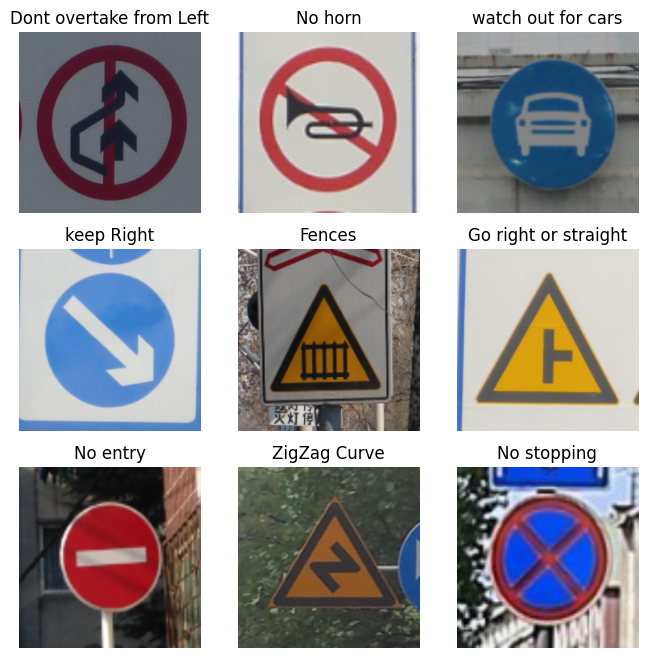

In [22]:
plt.figure(figsize=(8, 8))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(relabel(original_class_names[labels[i]]))
        plt.axis("off")

First, obtain a pre trained model, this can be done via the tensorflow keras API.  
Here we specify a model that has its weights trained on the ImageNet dataset, the expected image input size and that the classification top layer should be excluded

In [6]:
pretrained_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    input_shape=(71, 71, 3), # Input shape of our dataset images
    classes=original_class_names,
    include_top=False)  # Exclude the classifier layer, as our own will be used

Block the pretrained layers/base-model from having its weights changed during training

In [7]:
pretrained_model.trainable = False

Now, lets create our own model

In [8]:
model = keras.Sequential(
    [
        keras.Input(shape=(71, 71, 3)),
        keras.layers.Rescaling(scale=1 / 127.5, offset=-1),
        pretrained_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(len(original_class_names)),
    ])

# inputs = keras.Input(shape=(71, 71, 3))

# # Add normalizer layer scale to change the image data from 0-255 to -1-1
# scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
# x = scale_layer(x)

# x = pretrained_model(inputs, training=False)
# # Convert features of shape `base_model.output_shape[1:]` to vectors
# x = keras.layers.GlobalAveragePooling2D()(x)
# # A Dense classifier with a single unit (binary classification)
# outputs = keras.layers.Dense(len(original_class_names))(x)
# model = keras.Model(inputs, outputs)

Lets take a quick look at the internal layers of the pretrained model and our model

In [9]:
pretrained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 71, 71, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 35, 35, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 35, 35, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 35, 35, 32)           0         ['block1_conv1_bn[0][0]

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 71, 71, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 58)                118842    
                                                                 
Total params: 20980322 (80.03 MB)
Trainable params: 118842 (464.23 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


Now lets get our train and validation datasets.  
These datasets will be split 8:2, the images given are however not normalized with a large range of image sizes, from 72x62 to 265x265

In [73]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory, 
    labels="inferred",
    subset="training",
    seed=123,
    validation_split=0.2)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory, 
    labels="inferred",
    subset="validation",
    seed=123,
    validation_split=0.2)

Found 4170 files belonging to 58 classes.
Using 3336 files for training.


c:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 4170 files belonging to 58 classes.
Using 834 files for validation.


Normalize the images  
(71x71 is chosen, as this is the minimum input size allowed for the pretrained xception model, so keeping the input the same will hopefully allow for a better result than downsampling the input even further)

In [74]:
size = (71, 71)

train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(x, size), y))

Lets train this new model

In [13]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
105/105 [==============================] - 41s 356ms/step - loss: 1.5377 - accuracy: 0.6406 - val_loss: 0.6635 - val_accuracy: 0.8489
Epoch 2/10
105/105 [==============================] - 41s 392ms/step - loss: 0.4289 - accuracy: 0.9167 - val_loss: 0.3782 - val_accuracy: 0.9173
Epoch 3/10
105/105 [==============================] - 43s 404ms/step - loss: 0.2387 - accuracy: 0.9586 - val_loss: 0.2824 - val_accuracy: 0.9388
Epoch 4/10
105/105 [==============================] - 38s 363ms/step - loss: 0.1609 - accuracy: 0.9742 - val_loss: 0.2106 - val_accuracy: 0.9616
Epoch 5/10
105/105 [==============================] - 39s 370ms/step - loss: 0.1155 - accuracy: 0.9853 - val_loss: 0.1782 - val_accuracy: 0.9616
Epoch 6/10
105/105 [==============================] - 40s 376ms/step - loss: 0.0875 - accuracy: 0.9907 - val_loss: 0.1497 - val_accuracy: 0.9760
Epoch 7/10
105/105 [==============================] - 39s 368ms/step - loss: 0.0691 - accuracy: 0.9952 - val_loss: 0.1314 - val_ac

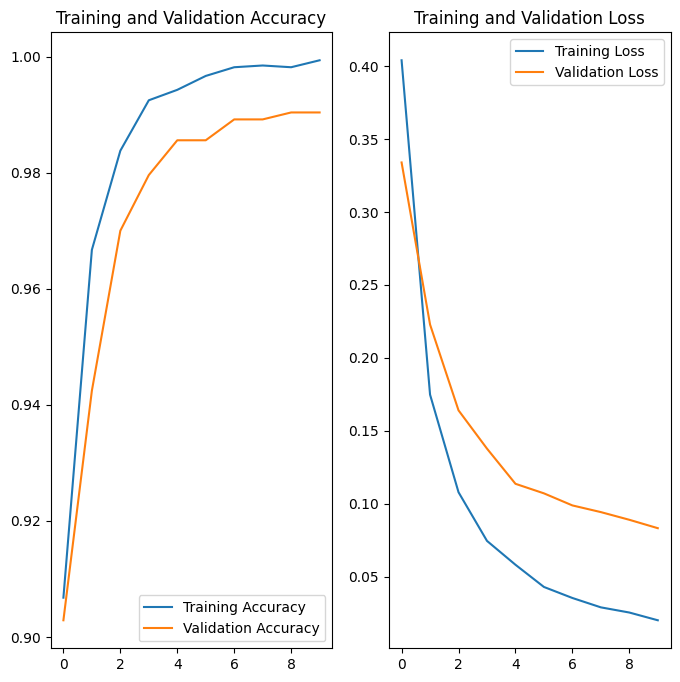

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

While the extremely high accuracy could indicate overfitting, the growth and consistent gap between training and validating dataset looks very promising (although this could be an indicator of overfitting)

Now lets get a test dataset to evaluate the model

In [75]:
test_directory = 'Dataset/traffic_Data/TEST/'

The test images aren't stored in the same tensorflow structure as the train/val data, so extra processing will have to be done.
The images are all in a single folder, with the label being encoded as the first number in the file name (e.g. xxx_0000.png)

In [76]:
def load_test_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)  # decode image into RGB channels
    img = tf.image.resize(img, (71, 71))  # Resize image to 71x71 just as the training set

    return img

def extract_label(file_path):
     # Split the file_path based on the directory separator ("/" or "\")
    parts = tf.strings.split(file_path, '\\')
    # Select the last part, which is the file name
    file_name = parts[-1]

    # Get numerical chars from the filename before the _ char
    label = tf.strings.regex_replace(file_name, r'^(.*?)_.+$', r'\1')
    
    return label

In [77]:
test_image_paths = tf.data.Dataset.list_files(test_directory + '*.png')

test_dataset = test_image_paths.map(lambda x: (load_test_image(x), int(extract_label(x))))

In [78]:
# Batch and prefetch the dataset
batch_size = 32
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Lets see if I properly loaded in the testdata, as this took a significant amount of messing around

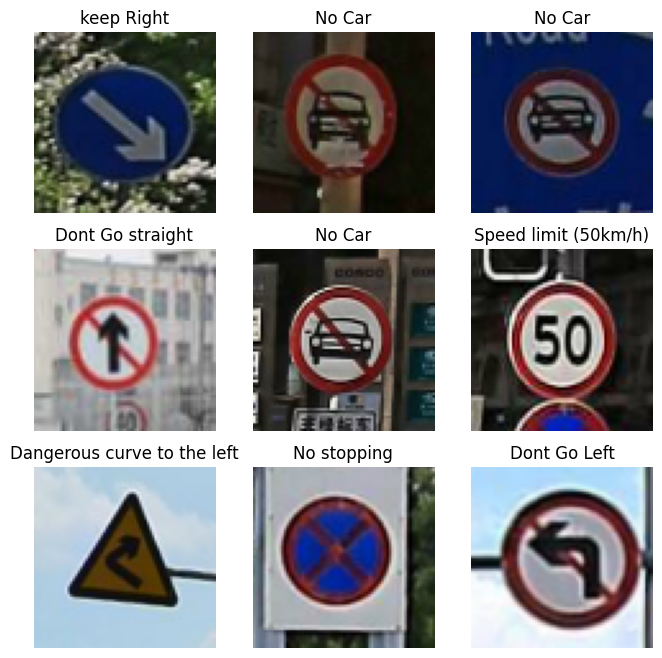

In [79]:
plt.figure(figsize=(8, 8))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(relabel(labels[i]))
        plt.axis("off")

Lets resize the test dataset just as done with the train and val datasets

In [80]:
test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, size), y))

Now we can evaluate the model based on the test dataset

In [20]:
metrics = model.evaluate(test_dataset, verbose=1)

63/63 [==============================] - 16s 256ms/step - loss: 11.0015 - accuracy: 0.0160


Well, an accuracy of 0.0160 was definitely not expected... This might indicate that the model is extremely overfitted. However, there is still a massive deviation between the validation accuracy and the testing accuracy here (validation accuracy was still ~99%)

Lets try getting the test dataset again, but this time in the same way as the train/val dataset by restructuring the files

In [81]:
import os
import shutil

# Directory containing the images
source_dir = 'Dataset/traffic_Data/TEST'

# Create a target directory to organize the images
target_dir = 'Dataset/traffic_Data/TEST_RESTRUCTURED'
os.makedirs(target_dir, exist_ok=True)

# Iterate through the files in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith('.png'):
        # Extract the folder name (e.g., "000") from the filename
        folder_name = filename.split('_')[0]
        
        # Create the target folder if it doesn't exist
        target_folder = os.path.join(target_dir, str(int(folder_name)))
        os.makedirs(target_folder, exist_ok=True)
        
        # Construct the source and target file paths
        source_file = os.path.join(source_dir, filename)
        target_file = os.path.join(target_folder, filename)
        
        # Move the image to the corresponding subfolder
        shutil.copy(source_file, target_file)

print("Images organized successfully.")

Images organized successfully.


The testing dataset could also be so far off, due to the train/val dataset labels, becoming skewed from the intended indexes.  
As was encountered when trying to plot the dataset, the labels first had to go through its own class_names table before it could be relabeled with the csv lookup table

In [82]:
restructured_test_directory = 'Dataset/traffic_Data/TEST_RESTRUCTURED/'
restructured_test_dataset = tf.keras.utils.image_dataset_from_directory(
    restructured_test_directory, 
    labels="inferred",
    seed=123)

Found 1994 files belonging to 54 classes.


In [83]:
restructured_test_dataset = restructured_test_dataset.map(lambda x, y: (tf.image.resize(x, size), y))

In [25]:
metrics = model.evaluate(restructured_test_dataset, verbose=1)

63/63 [==============================] - 16s 253ms/step - loss: 7.5406 - accuracy: 0.1474


The accuracy actually went up to ~14%, which is still bad, but it might show that there was something wrong with the way the dataset was imported 

I believe that this is due to the labels given to the dataset by tensorflow, as mentioned earlier.

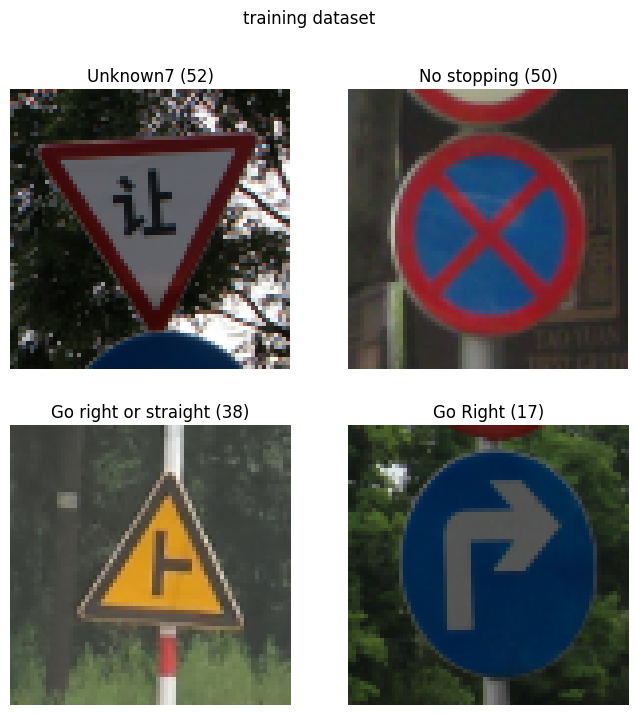

In [136]:
plt.figure(figsize=(8, 8))
plt.suptitle("training dataset")

for images, labels in train_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'{relabel(original_class_names[labels[i]])} ({labels[i].numpy()})')
        plt.axis("off")

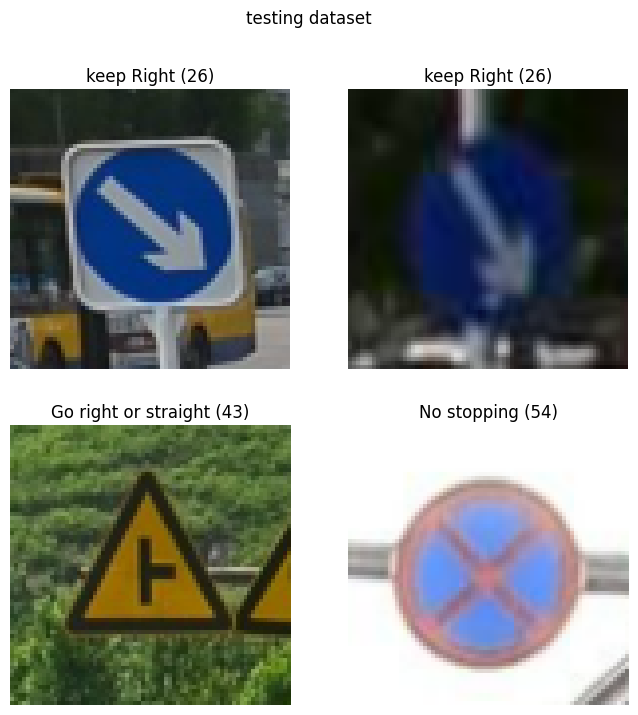

In [84]:
plt.figure(figsize=(8, 8))
plt.suptitle("testing dataset")

for images, labels in test_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'{relabel(labels[i])} ({labels[i].numpy()})')
        plt.axis("off")

As I supsected, the label numbering are actually complete different, as oberved with the "No stopping" images

Just in case, let me also check the validation dataset

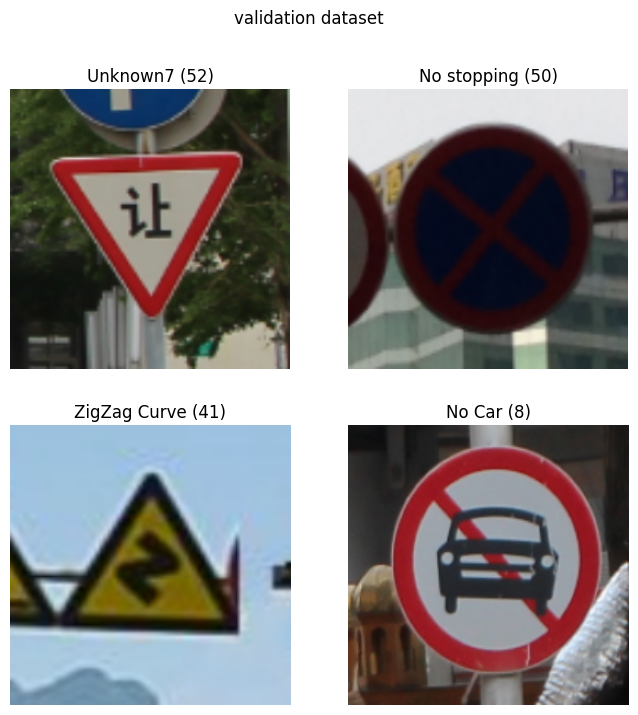

In [120]:
plt.figure(figsize=(8, 8))
plt.suptitle("validation dataset")

for images, labels in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'{relabel(original_class_names[labels[i]])} ({labels[i].numpy()})')
        plt.axis("off")

The validation dataset, looks to have its classes encoded in the same way as the training dataset, which makes sense as the validation accuracy stayed more in line of expectations during training

First, lets just normalize the train/val datasets to avoid the previously required original_class_names conversion

In [212]:
train_val_index_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(np.arange(len(original_class_names)), dtype=tf.int32),
        values=tf.constant(list(map(int, original_class_names)), dtype=tf.int32),
    ),
    default_value= tf.constant(len(original_class_names),  dtype=tf.int32)
)

def re_index_labels(image, label):
    # Use the hash table to map old labels to new labels
    new_label = train_val_index_table.lookup(label)
    return image, new_label

In [224]:
relabeled_train_dataset = train_dataset.map(re_index_labels)
relabeled_val_dataset = val_dataset.map(re_index_labels)

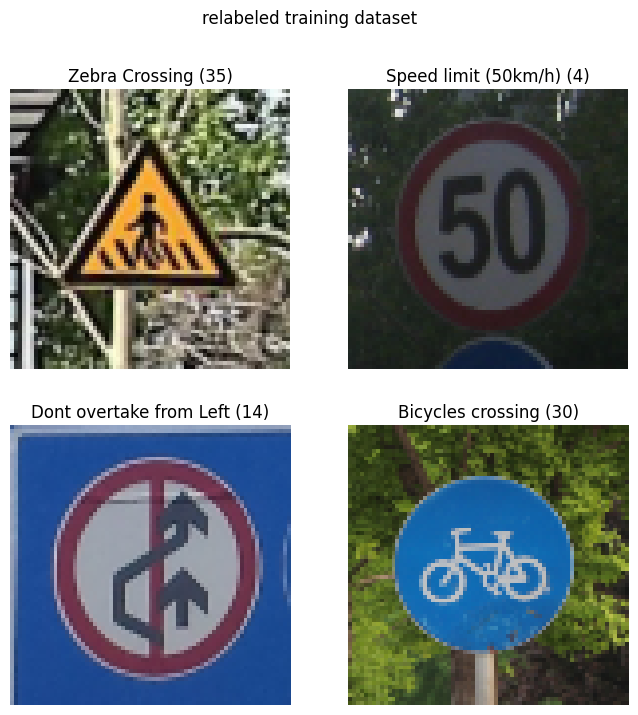

In [239]:
plt.figure(figsize=(8, 8))
plt.suptitle("relabeled training dataset")

for images, labels in relabeled_train_dataset:
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'{relabel(labels[i].numpy())} ({labels[i].numpy()})')
        plt.axis("off")

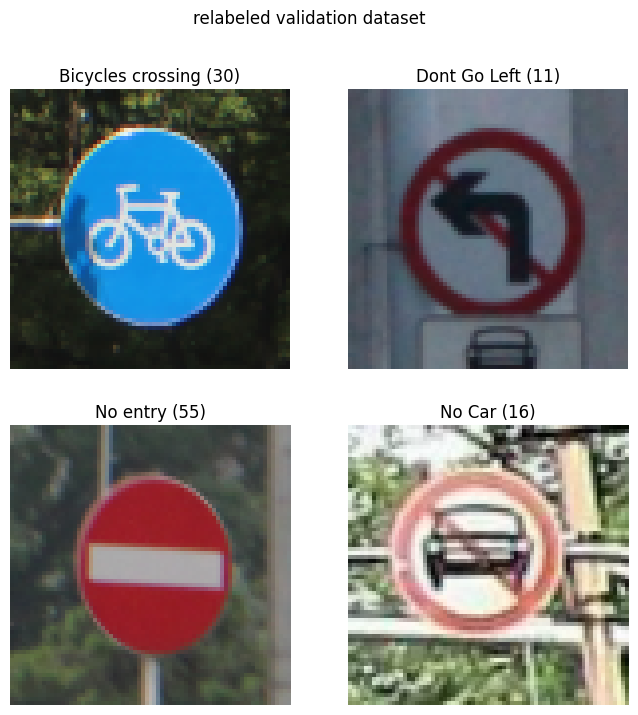

In [240]:
plt.figure(figsize=(8, 8))
plt.suptitle("relabeled validation dataset")

for images, labels in relabeled_val_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'{relabel(labels[i].numpy())} ({labels[i].numpy()})')
        plt.axis("off")

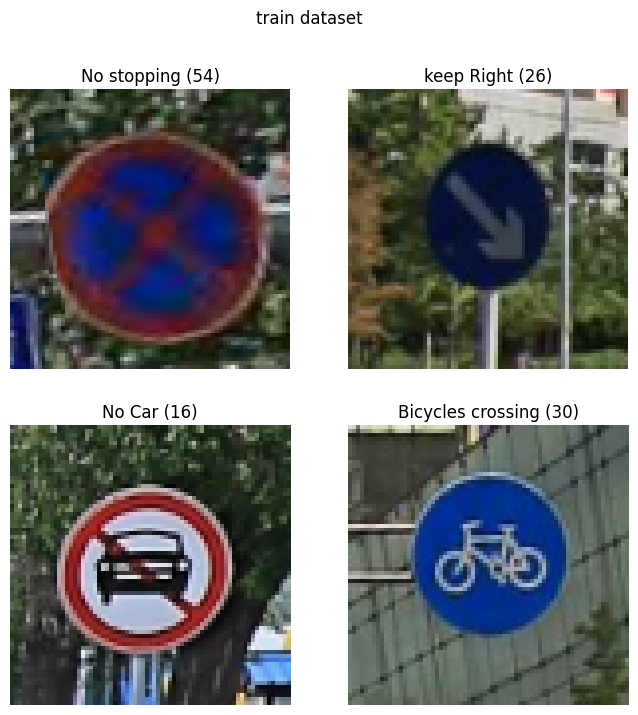

In [243]:
plt.figure(figsize=(8, 8))
plt.suptitle("train dataset")

for images, labels in test_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'{relabel(labels[i].numpy())} ({labels[i].numpy()})')
        plt.axis("off")

Just eyeballing it, it looks like the datasets all have the same labels now

So let's go ahead and retrain and evaluate the model

In [256]:
relabeled_pretrained_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    input_shape=(71, 71, 3), # Input shape of our dataset images
    include_top=False)  # Exclude the classifier layer, as our own will be used

relabeled_pretrained_model.trainable = False

relabeled_model = keras.Sequential(
    [
        keras.Input(shape=(71, 71, 3)),
        keras.layers.Rescaling(scale=1 / 127.5, offset=-1),
        relabeled_pretrained_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(len(original_class_names)),
    ])

relabeled_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
relabeled_history = relabeled_model.fit(relabeled_train_dataset, epochs=10, validation_data=relabeled_val_dataset)

Epoch 1/10
105/105 [==============================] - 438s 4s/step - loss: 1.5188 - accuracy: 0.6505 - val_loss: 0.6952 - val_accuracy: 0.8129
Epoch 2/10
105/105 [==============================] - 397s 4s/step - loss: 0.4150 - accuracy: 0.9170 - val_loss: 0.3841 - val_accuracy: 0.9161
Epoch 3/10
105/105 [==============================] - 241s 2s/step - loss: 0.2324 - accuracy: 0.9610 - val_loss: 0.2654 - val_accuracy: 0.9472
Epoch 4/10
105/105 [==============================] - 256s 2s/step - loss: 0.1548 - accuracy: 0.9808 - val_loss: 0.2196 - val_accuracy: 0.9556
Epoch 5/10
105/105 [==============================] - 255s 2s/step - loss: 0.1137 - accuracy: 0.9874 - val_loss: 0.1771 - val_accuracy: 0.9712
Epoch 6/10
105/105 [==============================] - 249s 2s/step - loss: 0.0858 - accuracy: 0.9910 - val_loss: 0.1454 - val_accuracy: 0.9772
Epoch 7/10
105/105 [==============================] - 224s 2s/step - loss: 0.0703 - accuracy: 0.9925 - val_loss: 0.1302 - val_accuracy: 0.9784

Let's evaluate

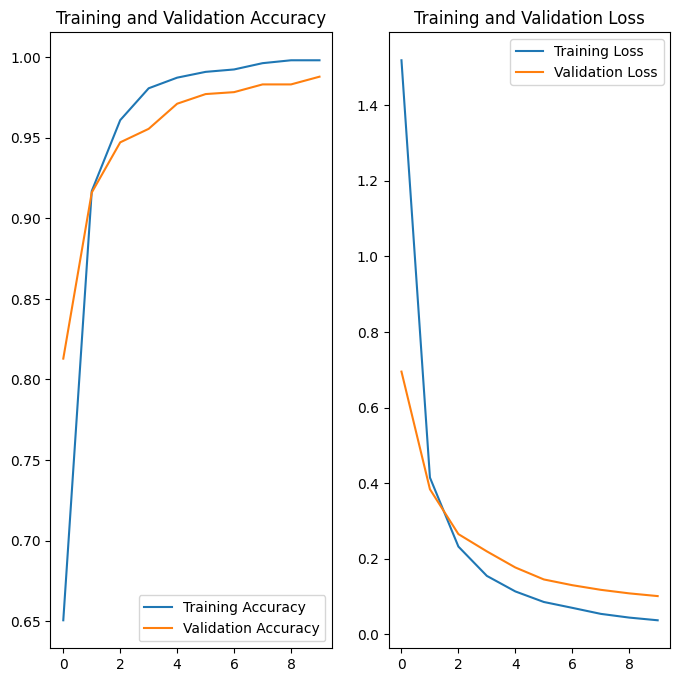

In [257]:
acc = relabeled_history.history['accuracy']
val_acc = relabeled_history.history['val_accuracy']

loss = relabeled_history.history['loss']
val_loss = relabeled_history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [259]:
relabeled_metrics = relabeled_model.evaluate(test_dataset, verbose=1)

63/63 [==============================] - 28s 440ms/step - loss: 2.4077 - accuracy: 0.4945


From the Evaluation on the test dataset, the accuracy is now just under 50%, which is a significant improvement over the previous 15%, proving my suspicions over the incorrect labeling of the datasets.

To improve this model even further dropout could be added to disable random neurons during training, this will force the model to achieve a higher level of accuracy without relying on the same neuron path every time, thereby avoiding overfitting. Furthermore, currently only a single Dense layer was used to get the output classes of the model, relying heavily on the pre-computed model, this could be expanded much further to help improve the model, as well as increasing the epoch count, and image resolution as it might be worth using a larger resolution than the (tf minimum for the precompiled model) of 71x71 pixels, thereby offering a higher level of detail then is possible with such as small image.

# Explainable AI
Below, I will try using the CNN trained with transferlearning on roadsigns, to create a Gradcam visualization of the POI taken by the model

Because I forgot to save my trained CNN model from before, I will have to train it again...  
So first lets load in the proper "correct" datasets, and afterwards trade the model *and save it*.

In [132]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import pandas as pd

from tensorflow import keras

Load in the datasets

In [133]:
image_size = (71, 71)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    "Dataset/traffic_Data/DATA/", 
    labels="inferred",
    subset="training",
    seed=123,
    validation_split=0.2)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    "Dataset/traffic_Data/DATA/", 
    labels="inferred",
    subset="validation",
    seed=123,
    validation_split=0.2)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    "Dataset/traffic_Data/TEST_RESTRUCTURED/", 
    labels="inferred",
    seed=123)



# get class name index
original_class_names = train_dataset.class_names
original_test_class_names = test_dataset.class_names

Found 4170 files belonging to 58 classes.
Using 3336 files for training.
Found 4170 files belonging to 58 classes.
Using 834 files for validation.
Found 1994 files belonging to 58 classes.


Re-index the train/val datasets to the intended class Ids for the labels lookup

In [134]:
train_val_index_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(np.arange(len(original_class_names)), dtype=tf.int32),
        values=tf.constant(list(map(int, original_class_names)), dtype=tf.int32),
    ),
    default_value= tf.constant(len(original_class_names), dtype=tf.int32)
)

def re_index_labels(image, label):
    # Use the hash table to map old labels to new labels
    new_label = train_val_index_table.lookup(label)
    return image, new_label

In [135]:
train_dataset = train_dataset.map(re_index_labels)
val_dataset = val_dataset.map(re_index_labels)
test_dataset = test_dataset.map(re_index_labels)

Create the label function to convert numeric class IDs to human readable labels

In [136]:
csv_labels = pd.read_csv(labels_path)
csv_labels_dict = classid_to_name = dict(zip(csv_labels['ClassId'], csv_labels['Name']))
def relabel(label):
    return csv_labels_dict[int(label)]

Normalize the image size, so they all have the same input shape

In [137]:
# Resize the datasets
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, image_size), y))
val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(x, image_size), y))
test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, image_size), y))

c:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Let's train the model and quickly re-evaluate the results

In [297]:
pretrained_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    input_shape=(71, 71, 3), # Input shape of our dataset images
    include_top=False)  # Exclude the classifier layer, as our own will be used

pretrained_model.trainable = False

model = keras.Sequential(
    [
        keras.Input(shape=(71, 71, 3)),
        keras.layers.Rescaling(scale=1 / 127.5, offset=-1),
        pretrained_model,
        keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(len(original_class_names)),
    ])


In [298]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_21 (Rescaling)    (None, 71, 71, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 conv2d_100 (Conv2D)         (None, 3, 3, 128)         2359424   
                                                                 
 global_average_pooling2d_2  (None, 128)               0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 58)                7482      
                                                     

In [299]:
# # Flatten model function to move all layers into a single model instead of having model reference layers
# def flatten_model(model):
#     flattened_layers = []
#     for layer in model.layers:
#         try:
#             flattened_layers.extend(layer.layers)
#         except AttributeError:
#             flattened_layers.append(layer)
#     # flattened_layers.insert(0, keras.Input(shape=(71, 71, 3)))
#     flattened_model = keras.models.Sequential(flattened_layers)
#     return flattened_model

In [300]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_train_history = model.fit(train_dataset, epochs=1, validation_data=val_dataset)

105/105 [==============================] - 237s 2s/step - loss: 1.6605 - accuracy: 0.6160 - val_loss: 0.7033 - val_accuracy: 0.8141


In [301]:
model_metrics = model.evaluate(test_dataset, verbose=1)

63/63 [==============================] - 27s 425ms/step - loss: 2.7558 - accuracy: 0.3721


# TODO: Re-run this on a larger dataset

Now let's attempt to use Grad-cam, for this I used the following [Grad-cam guide](https://keras.io/examples/vision/grad_cam/) that utilizes the Xception model, which I also used as the pre-trained model.

First, lets setup the logic that will go through the model and return a heatmap of the most prominently activated input pixels

In [302]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 1s 1s/step


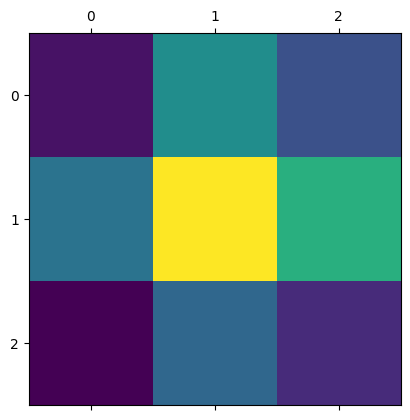

In [349]:
# Get the prediction
record = train_dataset.take(1)
image_arrays = None
image_labels = None
for image, label in record:
    image_arrays = image
    image_labels = label
prediction = model.predict(train_dataset.take(1))

# Get the last convolutional layer
last_conv_layer = None
for layer in reversed(model.layers):
    if 'conv2d' in layer.name.lower():  # Check if the layer is a convolutional layer
        last_conv_layer = layer
        break  # Stop after finding the last convolutional layer
    
# # Generate class activation heatmap
heatmap = make_gradcam_heatmap(image_arrays, model, last_conv_layer.name)

plt.matshow(heatmap)
plt.show()

C:\Users\Thomas\AppData\Local\Temp\ipykernel_9968\3034083465.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


(-0.5, 70.5, 70.5, -0.5)

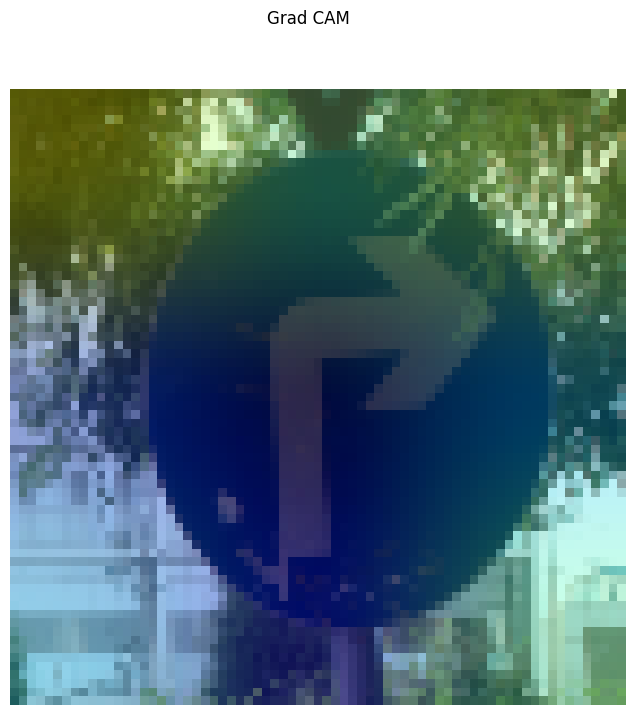

In [347]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Load the original image
img = image_arrays[0]

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img_array = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img_array)

# # Display Grad CAM
# display(superimposed_img)
plt.figure(figsize=(8, 8))
plt.suptitle("Grad CAM")

plt.imshow(superimposed_img)
plt.axis("off")
